<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: EOF analysis of monthly SST</h1>
<h3>Uses OpenDAP link to ERSST online at NOAA-PSD</h3>


<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Links to subsections
1. <a href="#opendap">OpenDAP: from a URL not a file</a>


In [4]:
# Old way was to download and use a file
#!wget ftp://ftp.cdc.noaa.gov/Datasets/noaa.ersst/sst.mnmean.nc # get the Extended Range SST data using wget,
                                                               # google ERSST for more information.

lon.mean

In [6]:
import xarray as xr 
datafile = xr.open_dataset('https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2/sst.mnmean.nc')
#datafile


<a name="graball"></a>
### Import all variables from dataset (not loaded yet: lazy virtual grab)

In [78]:
# Trick: a loop over all keys, building a command string. 
# Then, execute that command string!
for key in datafile.variables.keys(): 
    print( key +"=datafile['"+key+"'][:].squeeze()") # to show the command
    exec( key +"=datafile['"+key+"'][:].squeeze()")

lat=datafile['lat'][:].squeeze()
lon=datafile['lon'][:].squeeze()
time=datafile['time'][:].squeeze()
time_bnds=datafile['time_bnds'][:].squeeze()
sst=datafile['sst'][:].squeeze()


### Quick plot to check sanity of SST data array
## January: *it shows latitude is upside down*

In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(435, 180, 360)


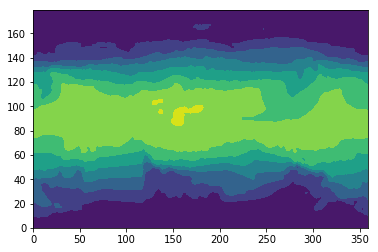

In [82]:
print( np.shape(sst) ) #should be months,lats,lons
#plt.contourf(lon, lat, sst.isel( time=(0) ))
plt.contourf(sst.isel( time=(0) ))

In [88]:
from datetime import datetime

oneyear = sst.sel(time=slice(datetime(2005,1,1),datetime(2005,12,1))).load()
tropicsst = oneyear.sel(lat=slice(30,-30))
tropicsst

<xarray.DataArray 'sst' (time: 12, lat: 60, lon: 360)>
array([[[17.42    , 17.46    , ..., 17.34    , 17.38    ],
        [17.82    , 17.85    , ..., 17.75    , 17.779999],
        ...,
        [22.369999, 22.289999, ..., 22.47    , 22.38    ],
        [22.18    , 22.119999, ..., 22.17    , 22.119999]],

       [[16.81    , 16.83    , ..., 16.789999, 16.81    ],
        [17.279999, 17.289999, ..., 17.26    , 17.27    ],
        ...,
        [22.85    , 22.779999, ..., 23.07    , 22.98    ],
        [22.75    , 22.67    , ..., 22.9     , 22.85    ]],

       ...,

       [[20.63    , 20.76    , ..., 20.39    , 20.51    ],
        [20.939999, 21.06    , ..., 20.699999, 20.82    ],
        ...,
        [19.25    , 19.08    , ..., 19.76    , 19.539999],
        [18.96    , 18.8     , ..., 19.4     , 19.22    ]],

       [[19.15    , 19.22    , ..., 19.01    , 19.08    ],
        [19.51    , 19.58    , ..., 19.39    , 19.449999],
        ...,
        [20.82    , 20.609999, ..., 21.449999, 2

In [89]:
tropiclat = lat.sel(lat=slice(30,-30)).load()
tropiclat

<xarray.DataArray 'lat' (lat: 60)>
array([ 29.5,  28.5,  27.5,  26.5,  25.5,  24.5,  23.5,  22.5,  21.5,  20.5,
        19.5,  18.5,  17.5,  16.5,  15.5,  14.5,  13.5,  12.5,  11.5,  10.5,
         9.5,   8.5,   7.5,   6.5,   5.5,   4.5,   3.5,   2.5,   1.5,   0.5,
        -0.5,  -1.5,  -2.5,  -3.5,  -4.5,  -5.5,  -6.5,  -7.5,  -8.5,  -9.5,
       -10.5, -11.5, -12.5, -13.5, -14.5, -15.5, -16.5, -17.5, -18.5, -19.5,
       -20.5, -21.5, -22.5, -23.5, -24.5, -25.5, -26.5, -27.5, -28.5, -29.5],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 29.5 28.5 27.5 26.5 25.5 24.5 23.5 22.5 21.5 20.5 ...
Attributes:
    units:               degrees_north
    long_name:           Latitude
    actual_range:        [ 89.5 -89.5]
    standard_name:       latitude
    axis:                Y
    coordinate_defines:  center

In [90]:
from eofs.standard import Eof # import standard eofs from python eofs package, 
                              # to install eofs package use `conda install eofs` in environment you want to add it to
                              # for API see http://ajdawson.github.io/eofs/api/index.html for more information.

In [99]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights (area weighting of variance) is applied before the computation of EOFs.

# coslat = np.cos(np.deg2rad(tropiclat))
# wgts = np.sqrt(coslat)[:, np.newaxis]

#solver = Eof( tropics.data, wgts )

solver = Eof( tropics.data )

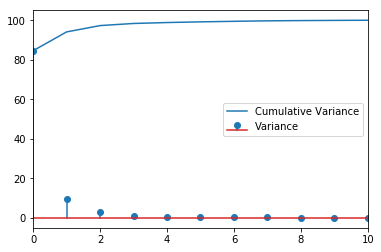

In [140]:
variance=solver.varianceFraction() # this is same as eigenvals/sum(eigenvals)

plt.stem(variance*100.0,label="Variance")
plt.plot(variance.cumsum()*100.0,label="Cumulative Variance")
plt.xlim(0,10,1)
plt.legend()

In [143]:
# Retrieve the EOFs and PCs
eofs = solver.eofs()

# Retrieve the EOF expressed as the correlation between the leading  PC time series 
# and the input SST anomalies at each grid point.
eofsasCorr = solver.eofsAsCorrelation()

# Retrieve the EOF expressed as the covariance between the leading  PC time series 
# and the input SST anomalies at each grid point.
eofsasCov = solver.eofsAsCovariance()

# Get the leading PC timeseries
pcs = solver.pcs()

eigenvals=solver.eigenvalues()

60 360 (60, 360)


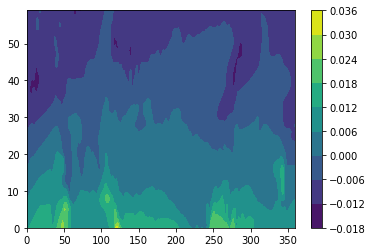

In [149]:
# Plot the leading EOF

plt.contourf(eofs[0,:,:]); plt.colorbar()
# plt.contourf(tropiclat, lon, eof1[0,:,:])
print(np.size(tropiclat), np.size(lon), np.shape(eof1[0,:,:]))

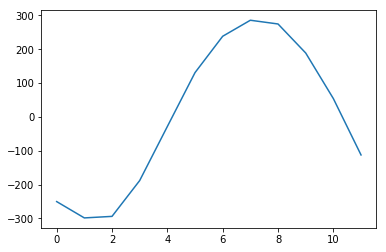

In [154]:
plt.plot(pcs[:,0])

#### Question: What physical mode does the plot of EOF1 above represent? 

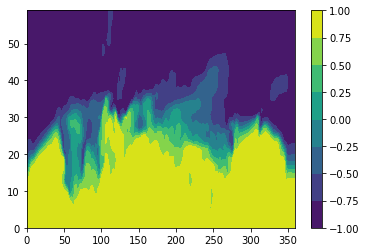

In [146]:
# Plot the leading EOF as correlation map
plt.contourf(eofsasCorr[0,:,:]); plt.colorbar()

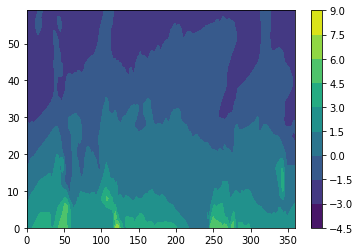

In [147]:
# Plot the leading EOF as covariance map
plt.contourf(eofsasCov[0,:,:]); plt.colorbar()

In [ ]:
plotmapcolor(eof1asCov[0,:,:],lats,lons) # Eof1 expressed as covariance between PC1 and SSt anamolies

### Solve for second EOF and plot it

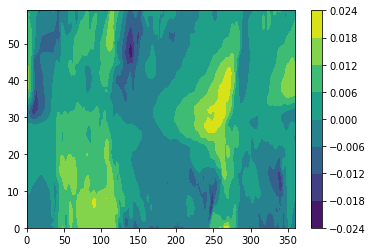

In [138]:
eof2 = solver.eofs(neofs=2)[1,:,:]
np.shape(eof2)
plt.contourf(eof2); plt.colorbar()

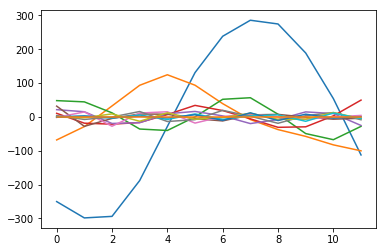

In [135]:
plt.plot(solver.pcs())

#### Question: What physical mode does the plot of EOF2 above represent?

## Questions:
### 1. Subset the data to a region, say pacific (100E to 270E and 20S to 40N) and perform EOF analysis like above. Would the percent of variance exprressed by each EOF change? 
### 2. Above data is monthly data, subtract seasonal cycle (using longterm monthly means) and perform EOF analysis. How do you expect EOF1 to look like?
### 3. PC1 and PC2 of above question are a multi-year monthly time series. Express PCs as standard deviation along each calender month and explain what it means.   
### 4. Average the monthly data for each year to produce yearly SST. Perform EOF analysis on yearly SST dataset and describe the modes. 
### 5. Assume we add a random noise to the original SST dataset at each grid point. What do you expect it does to EOF analysis?
### 6. What are the units of EOFs when expressed in different forms as shown in the first example of this notebook. Is there a preferable way to express EOFs? 